In [15]:
import torch
import torch.nn as nn
import numpy as np
import cv2
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt 

feature_maps = {}
gradients = {}

def save_feature_maps(module, input, output):
    """Forward hook to capture the Activations """
    feature_maps["A"] = output.detach() # Detach output to prevent memory leaks from storing tensors in the graph

def save_gradients(module, grad_input, grad_output):
    """Backward hook to capture the Gradients """
    gradients["grads"] = grad_output[0].detach()

In [ ]:
def grad_cam_pp(model, target_layer, input_tensor):
    """
    Calculates the Grad-CAM++ heatmap.
    
    Args:
        model (nn.Module): CNN model
        target_layer (nn.Module): The convolutional layer to target
        input_tensor (torch.Tensor): Input image (Batch x C x H x W)       
    Returns:
        np.ndarray: The heatmap.
    """
    
    forward_handle = target_layer.register_forward_hook(save_feature_maps)
    backward_handle = target_layer.register_full_backward_hook(save_gradients)
    
    input_tensor.requires_grad_(True) # Ensure the input tensor requires gradients for backpropagation

    output = model(input_tensor)
    target_class_idx = output.argmax(dim=1).item()
    target_logit = output[0, target_class_idx]

    model.zero_grad()
    target_logit.backward(retain_graph=True) 

    # Extract activations and gradients 
    A = feature_maps["A"]
    grads = gradients["grads"]

    forward_handle.remove()
    backward_handle.remove()

    # Reshape tensors (remove batch dimension)
    A = A.squeeze(0)
    grads = grads.squeeze(0)
  
    g_1 = grads.clamp(min=0) #Relu(grads)
    numerator = g_1.pow(2) 
    denominator = 2 * g_1.pow(2) + A.sum(dim=(1, 2), keepdim=True) * g_1.pow(3)

    # Avoid division by zero
    denominator = torch.where(denominator != 0.0, denominator, torch.ones_like(denominator))

    alpha_ij_kc = numerator / denominator
    W_k_c = (alpha_ij_kc * g_1).sum(dim=(1, 2), keepdim=True) 

    L_Grad_CAM_c = (W_k_c * A).sum(dim=0) 
    L_Grad_CAM_c = torch.relu(L_Grad_CAM_c).detach().cpu().numpy()
    L_Grad_CAM_c = L_Grad_CAM_c / L_Grad_CAM_c.max()

    heatmap = cv2.resize(L_Grad_CAM_c, (input_tensor.shape[3], input_tensor.shape[2])) #width: input_tensor.shape[3], height: input_tensor.shape[2]
    return heatmap

In [17]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

model.eval()

target_layer = model.layer4[-1].conv3 # Target layer for ResNet-50

img_path = "data\elephant.jpg" 
img = Image.open(img_path).convert("RGB")

preprocess = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
input_tensor = preprocess(img).unsqueeze(0)
heatmap_pp = grad_cam_pp(model, target_layer, input_tensor)


with torch.no_grad():
    prediction = model(input_tensor).argmax(dim=1).item()

<>:7: SyntaxWarning: invalid escape sequence '\e'
<>:7: SyntaxWarning: invalid escape sequence '\e'
C:\Users\LAY\AppData\Local\Temp\ipykernel_22976\123583213.py:7: SyntaxWarning: invalid escape sequence '\e'
  img_path = "data\elephant.jpg"


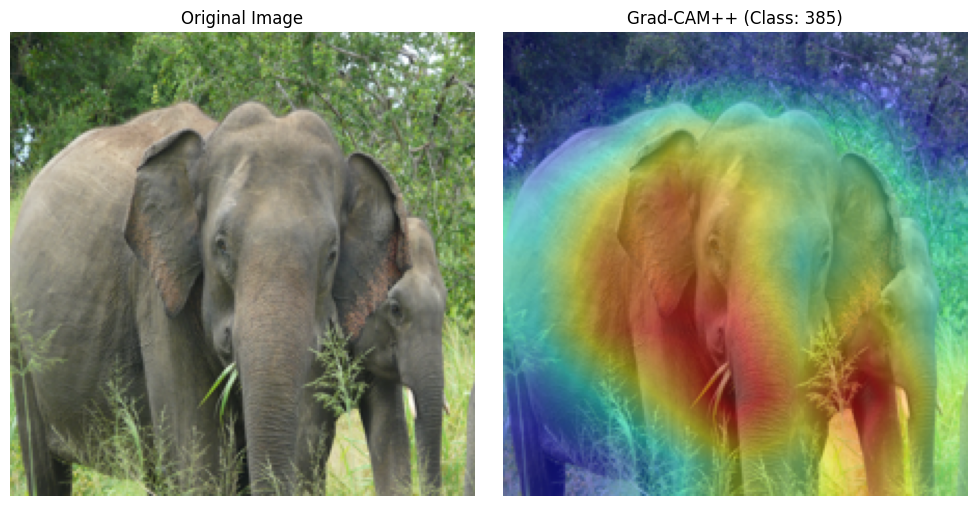

In [18]:
img_np = np.array(img.resize((224, 224)))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_pp), cv2.COLORMAP_JET)
heatmap_rgb = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB) 

alpha = 0.4 
img_np_float = img_np.astype(np.float32)
heatmap_rgb_float = heatmap_rgb.astype(np.float32)
superimposed_img = np.uint8((1 - alpha) * img_np_float + alpha * heatmap_rgb_float)


fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(img_np)
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(superimposed_img)
ax[1].set_title(f'Grad-CAM++ (Class: {prediction})')
ax[1].axis('off')

plt.tight_layout()
plt.show()